In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Предобработка датасета

In [3]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder 
import pandas as pd
import numpy as np

data = pd.read_csv("Steel_industry_data.csv")

scaler = MinMaxScaler()
ohe = OneHotEncoder(sparse_output=False)

cat_features = ["WeekStatus", "Day_of_week", "Load_Type"]
numeric_features = list(set(data.columns) - set(cat_features) - set(["date", "Usage_kWh"]))

one_hot_df = pd.DataFrame(ohe.fit_transform(data[cat_features]), 
                          columns=ohe.get_feature_names_out(cat_features))

data = pd.concat([data.drop(columns=cat_features), one_hot_df], axis=1)

data[numeric_features] = scaler.fit_transform(data[numeric_features])
data.drop(columns=["date"], inplace=True)
X = data.drop(columns=["Usage_kWh"]).to_numpy()
y = np.log(data["Usage_kWh"].to_numpy().reshape(-1, 1))
idx_to_drop = np.argwhere(y == y.min()).flatten()
X = np.delete(X, idx_to_drop, axis=0)
y = np.delete(y, idx_to_drop)


/var/folders/93/535pp3s56c53qkqt3srcr9fw0000gn/T/ipykernel_81199/3872055725.py:21: RuntimeWarning: divide by zero encountered in log
  y = np.log(data["Usage_kWh"].to_numpy().reshape(-1, 1))


In [4]:
X_train = X[:int(0.8 * len(X))]
y_train = y[:int(0.8 * len(y))]
X_test = X[int(0.8 * len(X)):]
y_test = y[int(0.8 * len(y)):]

In [5]:
window_size = 5
X_train_new = []
y_train_new = []
for row in range(window_size, X_train.shape[0]):
    X_train_new.append(X_train[row - window_size : row])
    y_train_new.append(y_train[row])

X_train = np.asarray(X_train_new)
y_train = np.asarray(y_train_new)

X_test_new = []
y_test_new = []
for row in range(window_size, X_test.shape[0]):
    X_test_new.append(X_test[row - window_size : row])
    y_test_new.append(y_test[row])

X_test = np.asarray(X_test_new)
y_test = np.asarray(y_test_new)

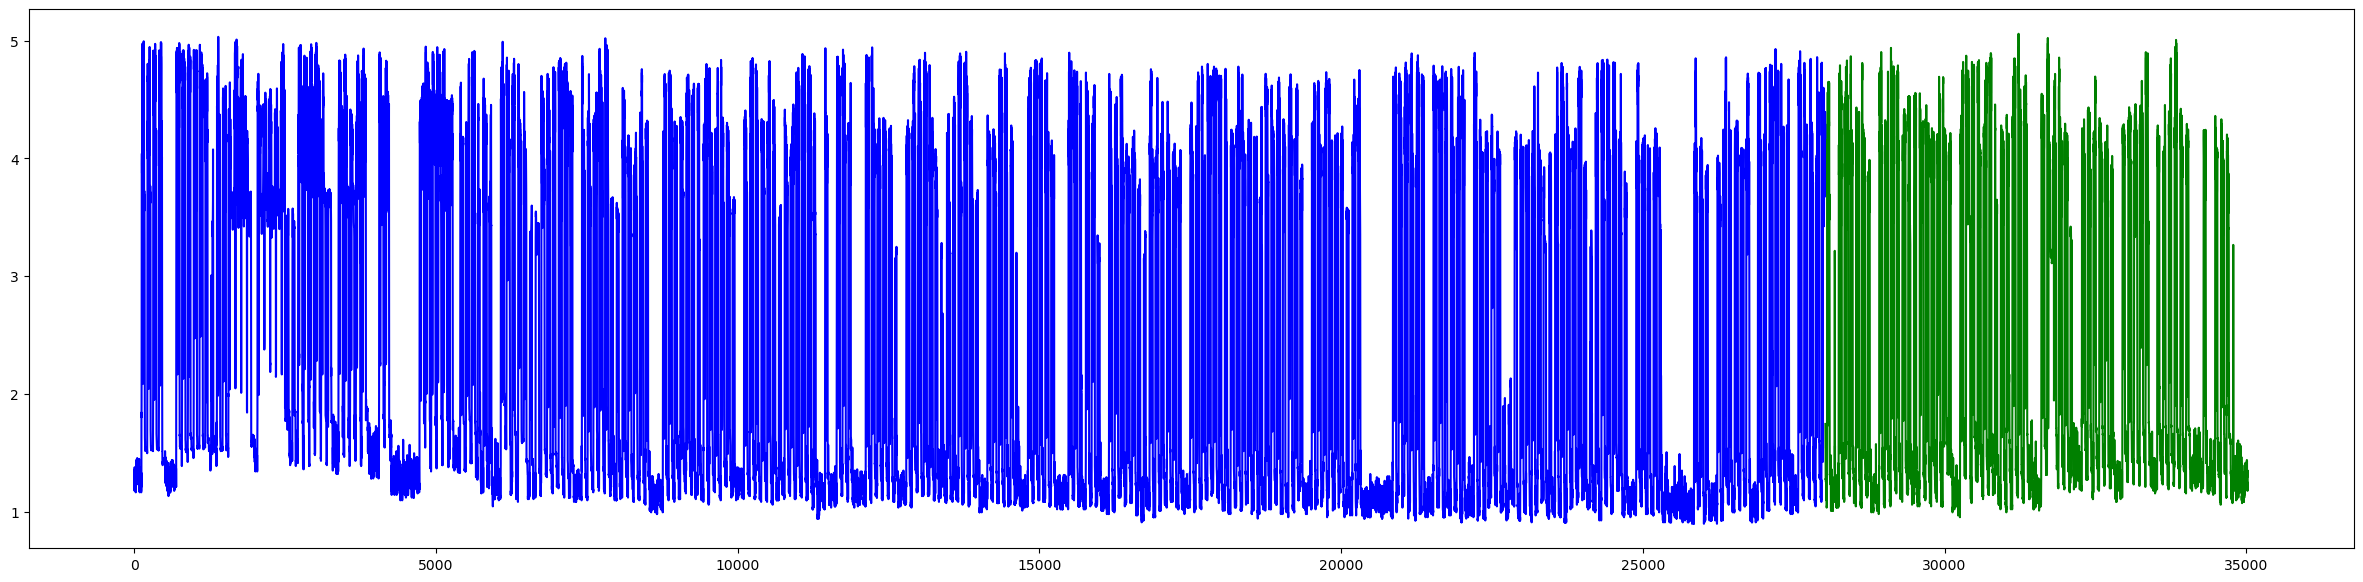

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 7))
plt.plot(y_train, label='True Usage (Train)', color='blue')
plt.plot(range(y_train.shape[0], y_train.shape[0] + y_test.shape[0]), y_test, label='True Usage (Test)', color='green')

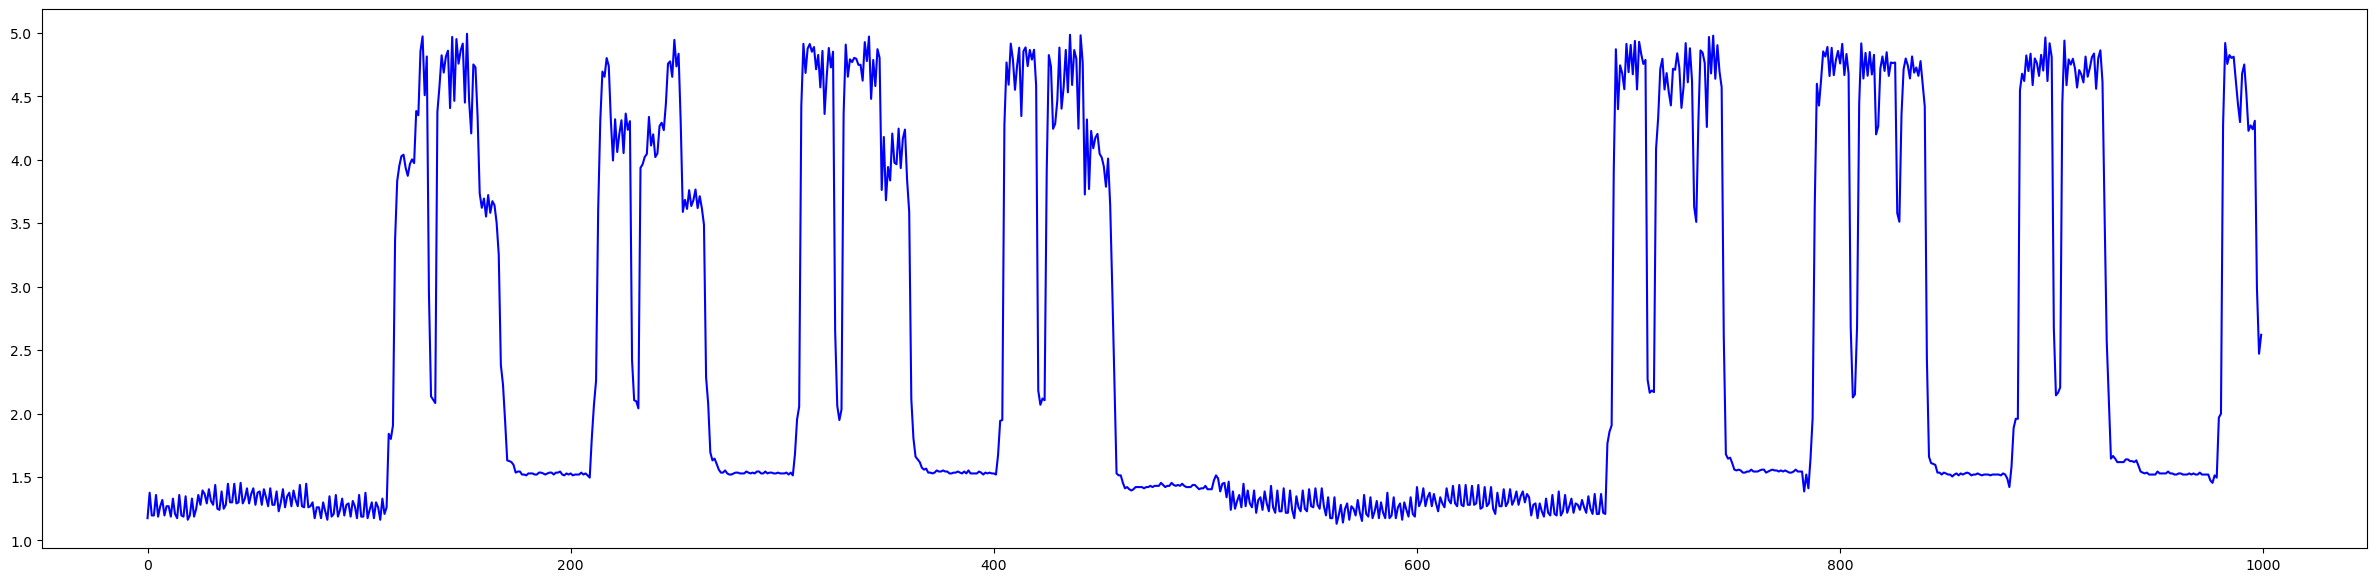

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 7))
plt.plot(y_train[:1000], label='True Usage (Train)', color='blue')

# RNN

In [7]:
from nn.rnn_model import SequenceRNN
from nn.losses.mse import MSE
from nn.optimizers.adam import Adam

n_in = 18
n_out = 1
n_hidden = 128
rnn_model = SequenceRNN(n_inputs=n_in, n_hidden=n_hidden, n_outputs=n_out, time_steps=5)
optimizer = Adam(learning_rate=0.001)
loss = MSE()

rnn_history = rnn_model.train(X_train, y_train, X_test, y_test, epochs=10, batch_size=128, learning_rate=1e-3, loss_fn=loss, optimizer=optimizer)

 99%|█████████▊| 216/218.9453125 [00:07<00:00, 28.19it/s]/Users/hq-q05j3pd44y/miniconda3/envs/amazme/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 219/218.9453125 [00:07<00:00, 28.36it/s]


Epoch 1/10 - loss: 0.8675 - val_loss: 0.3412


100%|██████████| 219/218.9453125 [00:07<00:00, 27.70it/s]


Epoch 2/10 - loss: 0.2773 - val_loss: 0.2543


100%|██████████| 219/218.9453125 [00:07<00:00, 28.34it/s]


Epoch 3/10 - loss: 0.2148 - val_loss: 0.2174


100%|██████████| 219/218.9453125 [00:07<00:00, 27.99it/s]


Epoch 4/10 - loss: 0.1958 - val_loss: 0.1872


100%|██████████| 219/218.9453125 [00:07<00:00, 28.25it/s]


Epoch 5/10 - loss: 0.1811 - val_loss: 0.1730


100%|██████████| 219/218.9453125 [00:07<00:00, 28.20it/s]


Epoch 6/10 - loss: 0.1778 - val_loss: 0.1651


100%|██████████| 219/218.9453125 [00:07<00:00, 28.40it/s]


Epoch 7/10 - loss: 0.1705 - val_loss: 0.1460


100%|██████████| 219/218.9453125 [00:07<00:00, 28.18it/s]


Epoch 8/10 - loss: 0.1640 - val_loss: 0.1367


100%|██████████| 219/218.9453125 [00:07<00:00, 27.74it/s]


Epoch 9/10 - loss: 0.1522 - val_loss: 0.1442


100%|██████████| 219/218.9453125 [00:07<00:00, 27.79it/s]


Epoch 10/10 - loss: 0.1498 - val_loss: 0.1363


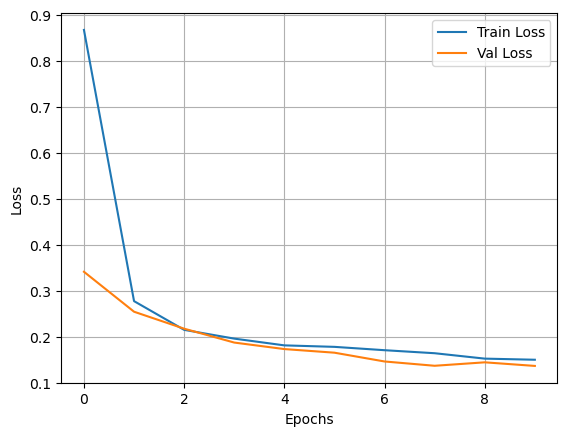

In [8]:
import matplotlib.pyplot as plt
plt.plot(rnn_history['train_loss'], label='Train Loss')
plt.plot(rnn_history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# GRU

In [9]:
from nn.gru_model import SequenceGRU
from nn.losses.mse import MSE
from nn.optimizers.adam import Adam

n_in = 18
n_out = 1
n_hidden = 128
optimizer = Adam(learning_rate=0.001)
gru_model = SequenceGRU(n_inputs=n_in, n_hidden=n_hidden, n_outputs=n_out, time_steps=5)
loss_fn = MSE()

gru_history = gru_model.train(X_train, y_train, X_test, y_test, epochs=10, batch_size=16, learning_rate=1e-3, loss_fn=loss_fn, optimizer=optimizer)

100%|█████████▉| 1746/1751.5625 [00:22<00:00, 80.33it/s]/Users/hq-q05j3pd44y/miniconda3/envs/amazme/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 1752/1751.5625 [00:22<00:00, 77.26it/s]


Epoch 1/10 - loss: 0.7278 - val_loss: 0.3336


100%|██████████| 1752/1751.5625 [00:22<00:00, 77.95it/s]


Epoch 2/10 - loss: 0.2652 - val_loss: 0.2405


100%|██████████| 1752/1751.5625 [00:22<00:00, 78.78it/s]


Epoch 3/10 - loss: 0.2128 - val_loss: 0.1987


100%|██████████| 1752/1751.5625 [00:22<00:00, 77.12it/s]


Epoch 4/10 - loss: 0.1944 - val_loss: 0.1837


100%|██████████| 1752/1751.5625 [00:23<00:00, 75.59it/s]


Epoch 5/10 - loss: 0.1818 - val_loss: 0.1765


100%|██████████| 1752/1751.5625 [00:22<00:00, 77.19it/s]


Epoch 6/10 - loss: 0.1765 - val_loss: 0.1718


100%|██████████| 1752/1751.5625 [00:22<00:00, 77.17it/s]


Epoch 7/10 - loss: 0.1734 - val_loss: 0.1831


100%|██████████| 1752/1751.5625 [00:22<00:00, 79.39it/s]


Epoch 8/10 - loss: 0.1698 - val_loss: 0.1628


100%|██████████| 1752/1751.5625 [00:22<00:00, 76.39it/s]


Epoch 9/10 - loss: 0.1668 - val_loss: 0.1627


100%|██████████| 1752/1751.5625 [00:22<00:00, 79.23it/s]


Epoch 10/10 - loss: 0.1662 - val_loss: 0.1646


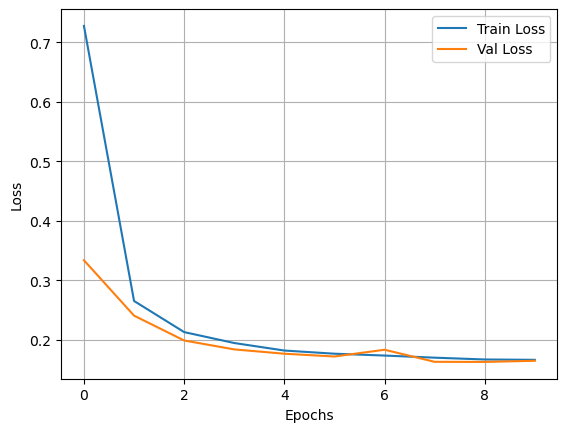

In [10]:
import matplotlib.pyplot as plt
plt.plot(gru_history['train_loss'], label='Train Loss')
plt.plot(gru_history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# LSTM

In [11]:
from nn.lstm_model import SequenceLSTM
from nn.losses.mse import MSE
from nn.optimizers.adam import Adam

n_in = 18
n_out = 1
n_hidden = 128
optimizer = Adam(learning_rate=0.001)
lstm_model = SequenceLSTM(n_inputs=n_in, n_hidden=n_hidden, n_outputs=n_out, time_steps=5)
loss_fn = MSE()

lstm_history = lstm_model.train(X_train, y_train, X_test, y_test, epochs=10, batch_size=16, learning_rate=1e-3, loss_fn=loss_fn)

100%|█████████▉| 1748/1751.5625 [00:32<00:00, 53.27it/s]/Users/hq-q05j3pd44y/miniconda3/envs/amazme/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 1752/1751.5625 [00:32<00:00, 53.63it/s]


Epoch 1/10 - loss: 0.7772 - val_loss: 0.4308


100%|██████████| 1752/1751.5625 [00:30<00:00, 56.57it/s]


Epoch 2/10 - loss: 0.3672 - val_loss: 0.3416


100%|██████████| 1752/1751.5625 [00:32<00:00, 53.36it/s]


Epoch 3/10 - loss: 0.2928 - val_loss: 0.2813


100%|██████████| 1752/1751.5625 [00:31<00:00, 54.77it/s]


Epoch 4/10 - loss: 0.2550 - val_loss: 0.2464


100%|██████████| 1752/1751.5625 [00:31<00:00, 55.48it/s]


Epoch 5/10 - loss: 0.2256 - val_loss: 0.2229


100%|██████████| 1752/1751.5625 [00:31<00:00, 55.72it/s]


Epoch 6/10 - loss: 0.2086 - val_loss: 0.1974


100%|██████████| 1752/1751.5625 [00:31<00:00, 55.94it/s]


Epoch 7/10 - loss: 0.1948 - val_loss: 0.1825


100%|██████████| 1752/1751.5625 [00:31<00:00, 55.49it/s]


Epoch 8/10 - loss: 0.1852 - val_loss: 0.1804


100%|██████████| 1752/1751.5625 [00:33<00:00, 52.74it/s]


Epoch 9/10 - loss: 0.1759 - val_loss: 0.1781


100%|██████████| 1752/1751.5625 [00:32<00:00, 53.44it/s]


Epoch 10/10 - loss: 0.1695 - val_loss: 0.1756


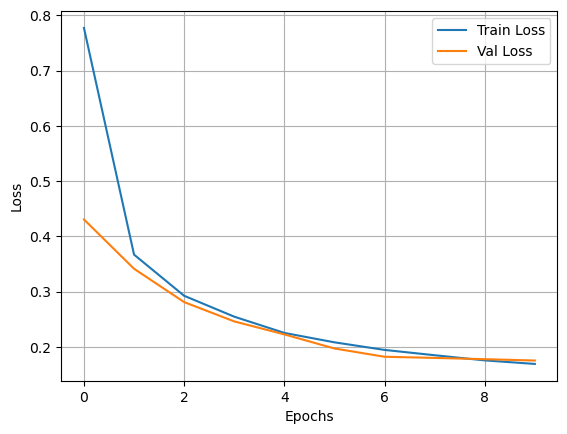

In [12]:
import matplotlib.pyplot as plt
plt.plot(lstm_history['train_loss'], label='Train Loss')
plt.plot(lstm_history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Сравнение моделей

In [ ]:
rnn_predictions = []
gru_predictions = []
lstm_predictions = []


for elem in X_test:
    rnn_predictions.append(rnn_model.forward(elem))
    gru_predictions.append(gru_model.forward(elem))
    lstm_predictions.append(lstm_model.forward(elem))
rnn_predictions = np.array(rnn_predictions).flatten()
gru_predictions = np.array(gru_predictions).flatten()
lstm_predictions = np.array(lstm_predictions).flatten()

In [22]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score

for predictions, model_type in zip([rnn_predictions, gru_predictions, lstm_predictions], ["rnn", "gru", "lstm"]):
    print(model_type)
    print(f"\t MSE = {mean_squared_error(y_test, predictions):.4f} RMSE = {root_mean_squared_error(y_test, predictions):.4f} r2_score = {r2_score(y_test, predictions):.4f}")

rnn
	 MSE = 0.2727 RMSE = 0.5222 r2_score = 0.8478
gru
	 MSE = 0.3292 RMSE = 0.5737 r2_score = 0.8162
lstm
	 MSE = 0.3513 RMSE = 0.5927 r2_score = 0.8039


# Window = 10

In [23]:
X_train = X[:int(0.8 * len(X))]
y_train = y[:int(0.8 * len(y))]
X_test = X[int(0.8 * len(X)):]
y_test = y[int(0.8 * len(y)):]

In [24]:
window_size = 10
X_train_new = []
y_train_new = []
for row in range(window_size, X_train.shape[0]):
    X_train_new.append(X_train[row - window_size : row])
    y_train_new.append(y_train[row])

X_train = np.asarray(X_train_new)
y_train = np.asarray(y_train_new)

X_test_new = []
y_test_new = []
for row in range(window_size, X_test.shape[0]):
    X_test_new.append(X_test[row - window_size : row])
    y_test_new.append(y_test[row])

X_test = np.asarray(X_test_new)
y_test = np.asarray(y_test_new)

# RNN

In [26]:
from nn.rnn_model import SequenceRNN
from nn.losses.mse import MSE
from nn.optimizers.adam import Adam

n_in = 18
n_out = 1
n_hidden = 128
rnn_model = SequenceRNN(n_inputs=n_in, n_hidden=n_hidden, n_outputs=n_out, time_steps=10)
optimizer = Adam(learning_rate=0.001)
loss = MSE()

rnn_history = rnn_model.train(X_train, y_train, X_test, y_test, epochs=10, batch_size=128, learning_rate=1e-3, loss_fn=loss, optimizer=optimizer)

100%|█████████▉| 218/218.90625 [00:14<00:00, 14.80it/s]/Users/hq-q05j3pd44y/miniconda3/envs/amazme/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 219/218.90625 [00:14<00:00, 14.81it/s]


Epoch 1/10 - loss: 0.9816 - val_loss: 0.3236


100%|██████████| 219/218.90625 [00:14<00:00, 14.62it/s]


Epoch 2/10 - loss: 0.2866 - val_loss: 0.2641


100%|██████████| 219/218.90625 [00:15<00:00, 14.44it/s]


Epoch 3/10 - loss: 0.2388 - val_loss: 0.2327


100%|██████████| 219/218.90625 [00:14<00:00, 14.84it/s]


Epoch 4/10 - loss: 0.2117 - val_loss: 0.2100


100%|██████████| 219/218.90625 [00:14<00:00, 15.09it/s]


Epoch 5/10 - loss: 0.1935 - val_loss: 0.1983


100%|██████████| 219/218.90625 [00:14<00:00, 15.11it/s]


Epoch 6/10 - loss: 0.2079 - val_loss: 0.1907


100%|██████████| 219/218.90625 [00:14<00:00, 15.08it/s]


Epoch 7/10 - loss: 0.1687 - val_loss: 0.1507


100%|██████████| 219/218.90625 [00:14<00:00, 15.04it/s]


Epoch 8/10 - loss: 0.1620 - val_loss: 0.1416


100%|██████████| 219/218.90625 [00:14<00:00, 15.09it/s]


Epoch 9/10 - loss: 0.1543 - val_loss: 0.1536


100%|██████████| 219/218.90625 [00:14<00:00, 15.09it/s]


Epoch 10/10 - loss: 0.1541 - val_loss: 0.1411


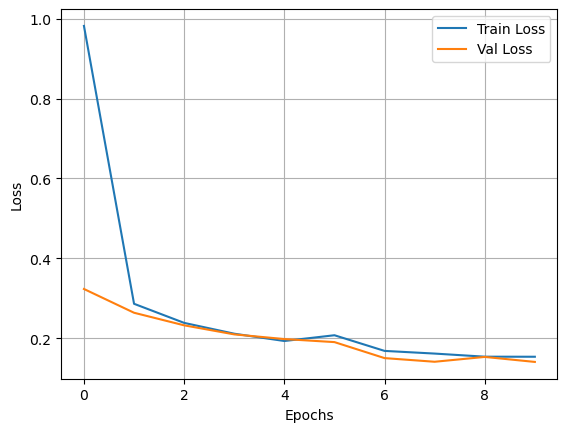

In [27]:
import matplotlib.pyplot as plt
plt.plot(rnn_history['train_loss'], label='Train Loss')
plt.plot(rnn_history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# GRU

In [28]:
from nn.gru_model import SequenceGRU
from nn.losses.mse import MSE
from nn.optimizers.adam import Adam

n_in = 18
n_out = 1
n_hidden = 128
optimizer = Adam(learning_rate=0.001)
gru_model = SequenceGRU(n_inputs=n_in, n_hidden=n_hidden, n_outputs=n_out, time_steps=10)
loss_fn = MSE()

gru_history = gru_model.train(X_train, y_train, X_test, y_test, epochs=10, batch_size=16, learning_rate=1e-3, loss_fn=loss_fn, optimizer=optimizer)

1752it [00:42, 41.01it/s]                             


Epoch 1/10 - loss: 0.5550 - val_loss: 0.2859


1752it [00:42, 41.05it/s]                             


Epoch 2/10 - loss: 0.2450 - val_loss: 0.2254


1752it [00:43, 40.18it/s]                             


Epoch 3/10 - loss: 0.2102 - val_loss: 0.2193


1752it [00:43, 39.99it/s]                             


Epoch 4/10 - loss: 0.1938 - val_loss: 0.1863


1752it [00:42, 41.28it/s]                             


Epoch 5/10 - loss: 0.1858 - val_loss: 0.1917


1752it [00:43, 40.19it/s]                             


Epoch 6/10 - loss: 0.1797 - val_loss: 0.1731


1752it [00:47, 36.92it/s]                             


Epoch 7/10 - loss: 0.1777 - val_loss: 0.1796


1752it [00:49, 35.65it/s]                             


Epoch 8/10 - loss: 0.1747 - val_loss: 0.1677


1752it [00:48, 36.19it/s]                             


Epoch 9/10 - loss: 0.1717 - val_loss: 0.1779


1752it [00:48, 36.30it/s]                             


Epoch 10/10 - loss: 0.1705 - val_loss: 0.1700


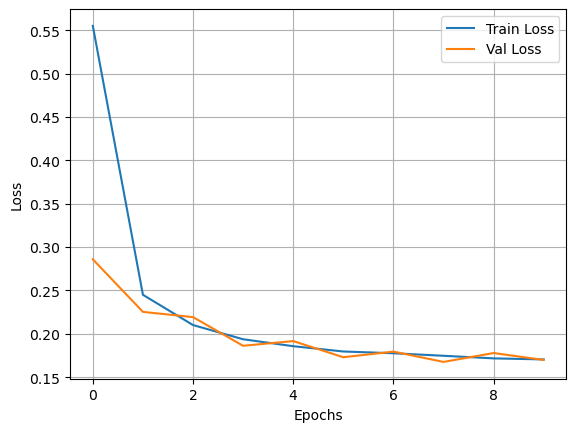

In [29]:
import matplotlib.pyplot as plt
plt.plot(gru_history['train_loss'], label='Train Loss')
plt.plot(gru_history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# LSTM

In [ ]:
46 34 19

In [38]:
from nn.lstm_model import SequenceLSTM
from nn.losses.mse import MSE
from nn.optimizers.adam import Adam

n_in = 18
n_out = 1
n_hidden = 128
optimizer = Adam(learning_rate=0.001)
lstm_model = SequenceLSTM(n_inputs=n_in, n_hidden=n_hidden, n_outputs=n_out, time_steps=10)
loss_fn = MSE()

lstm_history = lstm_model.train(X_train, y_train, X_test, y_test, epochs=10, batch_size=16, learning_rate=1e-3, loss_fn=loss_fn)

1752it [01:01, 28.69it/s]                             


Epoch 1/10 - loss: 0.7171 - val_loss: 0.4282


1752it [01:01, 28.33it/s]                             


Epoch 2/10 - loss: 0.3805 - val_loss: 0.3607


1752it [01:00, 28.83it/s]                             


Epoch 3/10 - loss: 0.3096 - val_loss: 0.3005


1752it [01:02, 28.22it/s]                             


Epoch 4/10 - loss: 0.2678 - val_loss: 0.2638


1752it [01:02, 28.00it/s]                             


Epoch 5/10 - loss: 0.2368 - val_loss: 0.2335


1752it [19:38,  1.49it/s]                                


Epoch 6/10 - loss: 0.2135 - val_loss: 0.2230


1752it [01:08, 25.66it/s]                             


Epoch 7/10 - loss: 0.1969 - val_loss: 0.1915


1752it [01:06, 26.52it/s]                             


Epoch 8/10 - loss: 0.1851 - val_loss: 0.1814


1752it [01:05, 26.91it/s]                             


Epoch 9/10 - loss: 0.1742 - val_loss: 0.1714


1752it [01:03, 27.57it/s]                             


Epoch 10/10 - loss: 0.1652 - val_loss: 0.1653


In [41]:
lstm_history_new = lstm_model.train(X_train, y_train, X_test, y_test, epochs=5, batch_size=16, learning_rate=1e-3, loss_fn=loss_fn)

1752it [01:02, 27.93it/s]                             


Epoch 1/5 - loss: 0.1575 - val_loss: 0.1659


1752it [01:06, 26.33it/s]                             


Epoch 2/5 - loss: 0.1518 - val_loss: 0.1560


1752it [01:02, 28.10it/s]                             


Epoch 3/5 - loss: 0.1463 - val_loss: 0.1550


1752it [01:04, 27.00it/s]                             


Epoch 4/5 - loss: 0.1408 - val_loss: 0.1467


1752it [01:03, 27.49it/s]                             


Epoch 5/5 - loss: 0.1360 - val_loss: 0.1431


In [42]:
lstm_history_new_v2 = lstm_model.train(X_train, y_train, X_test, y_test, epochs=5, batch_size=16, learning_rate=1e-3, loss_fn=loss_fn)

1752it [01:02, 27.88it/s]                             


Epoch 1/5 - loss: 0.1323 - val_loss: 0.1392


1752it [01:03, 27.61it/s]                             


Epoch 2/5 - loss: 0.1289 - val_loss: 0.1404


1752it [01:02, 27.87it/s]                             


Epoch 3/5 - loss: 0.1255 - val_loss: 0.1557


 16%|█▌        | 282/1751.25 [00:10<00:52, 27.81it/s]


KeyboardInterrupt: 

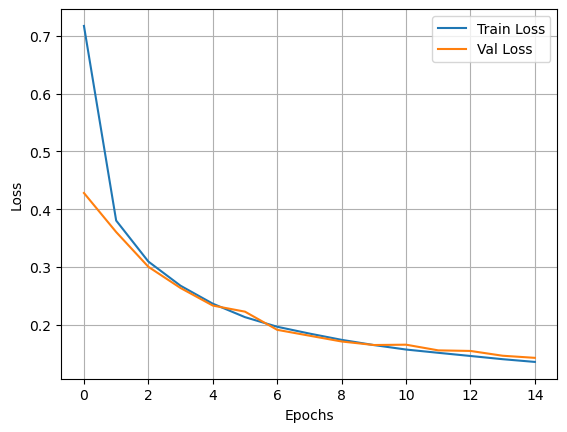

In [43]:
import matplotlib.pyplot as plt
plt.plot(lstm_history['train_loss'] + lstm_history_new['train_loss'], label='Train Loss')
plt.plot(lstm_history['val_loss'] + lstm_history_new['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [44]:
rnn_predictions = []
gru_predictions = []
lstm_predictions = []


for elem in X_test:
    rnn_predictions.append(rnn_model.forward(elem))
    gru_predictions.append(gru_model.forward(elem))
    lstm_predictions.append(lstm_model.forward(elem))
rnn_predictions = np.array(rnn_predictions).flatten()
gru_predictions = np.array(gru_predictions).flatten()
lstm_predictions = np.array(lstm_predictions).flatten()

In [45]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score

for predictions, model_type in zip([rnn_predictions, gru_predictions, lstm_predictions], ["rnn", "gru", "lstm"]):
    print(model_type)
    print(f"\t MSE = {mean_squared_error(y_test, predictions):.4f} RMSE = {root_mean_squared_error(y_test, predictions):.4f} r2_score = {r2_score(y_test, predictions):.4f}")

rnn
	 MSE = 0.2823 RMSE = 0.5313 r2_score = 0.8425
gru
	 MSE = 0.3399 RMSE = 0.5830 r2_score = 0.8103
lstm
	 MSE = 0.2853 RMSE = 0.5341 r2_score = 0.8408


# Window = 30

In [46]:
X_train = X[:int(0.8 * len(X))]
y_train = y[:int(0.8 * len(y))]
X_test = X[int(0.8 * len(X)):]
y_test = y[int(0.8 * len(y)):]

In [ ]:
window_size = 30
X_train_new = []
y_train_new = []
for row in range(window_size, X_train.shape[0]):
    X_train_new.append(X_train[row - window_size : row])
    y_train_new.append(y_train[row])

X_train = np.asarray(X_train_new)
y_train = np.asarray(y_train_new)

X_test_new = []
y_test_new = []
for row in range(window_size, X_test.shape[0]):
    X_test_new.append(X_test[row - window_size : row])
    y_test_new.append(y_test[row])

X_test = np.asarray(X_test_new)
y_test = np.asarray(y_test_new)

# RNN

In [48]:
from nn.rnn_model import SequenceRNN
from nn.losses.mse import MSE
from nn.optimizers.adam import Adam

n_in = 18
n_out = 1
n_hidden = 128
rnn_model = SequenceRNN(n_inputs=n_in, n_hidden=n_hidden, n_outputs=n_out, time_steps=30)
optimizer = Adam(learning_rate=0.001)
loss = MSE()

rnn_history = rnn_model.train(X_train, y_train, X_test, y_test, epochs=10, batch_size=128, learning_rate=1e-3, loss_fn=loss, optimizer=optimizer)

100%|█████████▉| 218/218.75 [00:44<00:00,  4.97it/s]/Users/hq-q05j3pd44y/miniconda3/envs/amazme/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 219/218.75 [00:44<00:00,  4.91it/s]


Epoch 1/10 - loss: 0.8305 - val_loss: 0.3516


100%|██████████| 219/218.75 [00:43<00:00,  5.05it/s]


Epoch 2/10 - loss: 0.2589 - val_loss: 0.2279


100%|██████████| 219/218.75 [00:42<00:00,  5.10it/s]


Epoch 3/10 - loss: 0.2042 - val_loss: 0.2118


100%|██████████| 219/218.75 [00:43<00:00,  5.08it/s]


Epoch 4/10 - loss: 0.1843 - val_loss: 0.1796


100%|██████████| 219/218.75 [00:41<00:00,  5.26it/s]


Epoch 5/10 - loss: 0.1710 - val_loss: 0.1581


100%|██████████| 219/218.75 [00:42<00:00,  5.21it/s]


Epoch 6/10 - loss: 0.1661 - val_loss: 0.1643


100%|██████████| 219/218.75 [00:43<00:00,  5.06it/s]


Epoch 7/10 - loss: 0.1598 - val_loss: 0.1500


100%|██████████| 219/218.75 [00:42<00:00,  5.13it/s]


Epoch 8/10 - loss: 0.1577 - val_loss: 0.1474


100%|██████████| 219/218.75 [00:43<00:00,  5.09it/s]


Epoch 9/10 - loss: 0.1550 - val_loss: 0.1483


100%|██████████| 219/218.75 [00:42<00:00,  5.19it/s]


Epoch 10/10 - loss: 0.1488 - val_loss: 0.1356


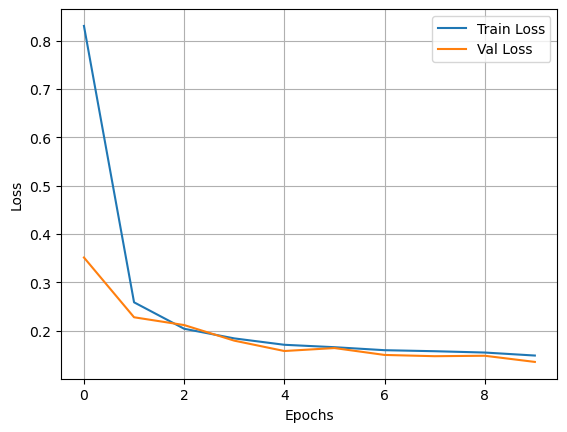

In [49]:
import matplotlib.pyplot as plt
plt.plot(rnn_history['train_loss'], label='Train Loss')
plt.plot(rnn_history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# GRU

In [51]:
from nn.gru_model import SequenceGRU
from nn.losses.mse import MSE
from nn.optimizers.adam import Adam

n_in = 18
n_out = 1
n_hidden = 128
optimizer = Adam(learning_rate=0.001)
gru_model = SequenceGRU(n_inputs=n_in, n_hidden=n_hidden, n_outputs=n_out, time_steps=30)
loss_fn = MSE()

gru_history = gru_model.train(X_train, y_train, X_test, y_test, epochs=10, batch_size=128, learning_rate=1e-3, loss_fn=loss_fn, optimizer=optimizer)

100%|██████████| 219/218.75 [02:39<00:00,  1.37it/s]


Epoch 1/10 - loss: 1.8488 - val_loss: 0.7161


100%|██████████| 219/218.75 [02:35<00:00,  1.41it/s]


Epoch 2/10 - loss: 0.6491 - val_loss: 0.4838


100%|██████████| 219/218.75 [02:42<00:00,  1.35it/s]


Epoch 3/10 - loss: 0.4865 - val_loss: 0.4268


100%|██████████| 219/218.75 [02:46<00:00,  1.32it/s]


Epoch 4/10 - loss: 0.4170 - val_loss: 0.3696


100%|██████████| 219/218.75 [02:41<00:00,  1.36it/s]


Epoch 5/10 - loss: 0.3657 - val_loss: 0.3469


100%|██████████| 219/218.75 [02:36<00:00,  1.40it/s]


Epoch 6/10 - loss: 0.3378 - val_loss: 0.3246


100%|██████████| 219/218.75 [02:34<00:00,  1.41it/s]


Epoch 7/10 - loss: 0.3161 - val_loss: 0.3015


100%|██████████| 219/218.75 [02:35<00:00,  1.41it/s]


Epoch 8/10 - loss: 0.2981 - val_loss: 0.2854


100%|██████████| 219/218.75 [02:35<00:00,  1.41it/s]


Epoch 9/10 - loss: 0.2880 - val_loss: 0.2788


100%|██████████| 219/218.75 [02:40<00:00,  1.36it/s]


Epoch 10/10 - loss: 0.2771 - val_loss: 0.2700


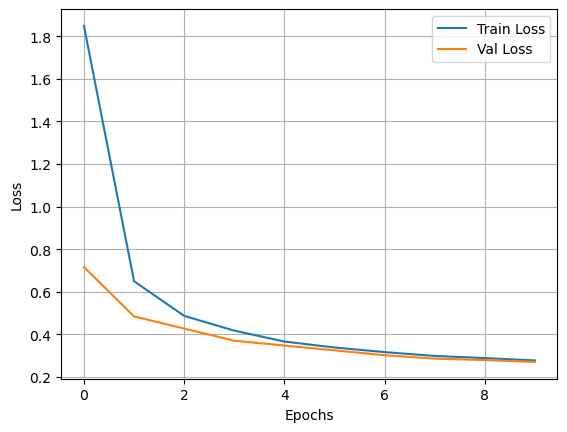

In [52]:
import matplotlib.pyplot as plt
plt.plot(gru_history['train_loss'], label='Train Loss')
plt.plot(gru_history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# LSTM

In [54]:
from nn.lstm_model import SequenceLSTM
from nn.losses.mse import MSE
from nn.optimizers.adam import Adam

n_in = 18
n_out = 1
n_hidden = 128
optimizer = Adam(learning_rate=0.001)
lstm_model = SequenceLSTM(n_inputs=n_in, n_hidden=n_hidden, n_outputs=n_out, time_steps=30)
loss_fn = MSE()

lstm_history = lstm_model.train(X_train, y_train, X_test, y_test, epochs=15, batch_size=32, learning_rate=1e-3, loss_fn=loss_fn)

100%|██████████| 875/875.0 [03:14<00:00,  4.50it/s]


Epoch 1/15 - loss: 0.9300 - val_loss: 0.6197


100%|██████████| 875/875.0 [03:14<00:00,  4.49it/s]


Epoch 2/15 - loss: 1.0321 - val_loss: 0.5933


100%|██████████| 875/875.0 [03:12<00:00,  4.54it/s]


Epoch 3/15 - loss: 0.5563 - val_loss: 0.4504


100%|██████████| 875/875.0 [03:12<00:00,  4.54it/s]


Epoch 4/15 - loss: 0.4233 - val_loss: 0.3826


100%|██████████| 875/875.0 [03:18<00:00,  4.41it/s]


Epoch 5/15 - loss: 0.3535 - val_loss: 0.3504


100%|██████████| 875/875.0 [03:17<00:00,  4.43it/s]


Epoch 6/15 - loss: 0.3122 - val_loss: 0.3187


100%|██████████| 875/875.0 [03:10<00:00,  4.58it/s]


Epoch 7/15 - loss: 0.2888 - val_loss: 0.3101


100%|██████████| 875/875.0 [03:11<00:00,  4.58it/s]


Epoch 8/15 - loss: 0.2649 - val_loss: 0.2764


100%|██████████| 875/875.0 [03:12<00:00,  4.54it/s]


Epoch 9/15 - loss: 0.2485 - val_loss: 0.2678


100%|██████████| 875/875.0 [03:18<00:00,  4.40it/s]


Epoch 10/15 - loss: 0.2407 - val_loss: 0.2495


100%|██████████| 875/875.0 [03:15<00:00,  4.47it/s]


Epoch 11/15 - loss: 0.2305 - val_loss: 0.3036


100%|██████████| 875/875.0 [03:29<00:00,  4.18it/s]


Epoch 12/15 - loss: 0.2195 - val_loss: 0.2311


100%|██████████| 875/875.0 [03:22<00:00,  4.33it/s]


Epoch 13/15 - loss: 0.2104 - val_loss: 0.2230


100%|██████████| 875/875.0 [03:18<00:00,  4.42it/s]


Epoch 14/15 - loss: 0.2008 - val_loss: 0.2102


100%|██████████| 875/875.0 [03:20<00:00,  4.36it/s]


Epoch 15/15 - loss: 0.1949 - val_loss: 0.2026


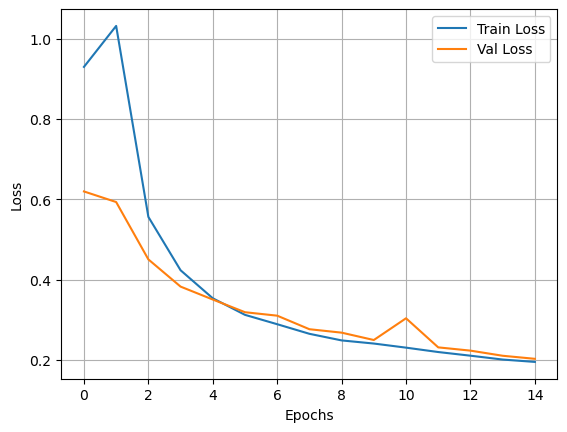

In [55]:
import matplotlib.pyplot as plt
plt.plot(lstm_history['train_loss'], label='Train Loss')
plt.plot(lstm_history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [56]:
rnn_predictions = []
gru_predictions = []
lstm_predictions = []


for elem in X_test:
    rnn_predictions.append(rnn_model.forward(elem))
    gru_predictions.append(gru_model.forward(elem))
    lstm_predictions.append(lstm_model.forward(elem))
rnn_predictions = np.array(rnn_predictions).flatten()
gru_predictions = np.array(gru_predictions).flatten()
lstm_predictions = np.array(lstm_predictions).flatten()

In [57]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score

for predictions, model_type in zip([rnn_predictions, gru_predictions, lstm_predictions], ["rnn", "gru", "lstm"]):
    print(model_type)
    print(f"\t MSE = {mean_squared_error(y_test, predictions):.4f} RMSE = {root_mean_squared_error(y_test, predictions):.4f} r2_score = {r2_score(y_test, predictions):.4f}")

rnn
	 MSE = 0.2712 RMSE = 0.5207 r2_score = 0.8488
gru
	 MSE = 0.5400 RMSE = 0.7348 r2_score = 0.6989
lstm
	 MSE = 0.4053 RMSE = 0.6366 r2_score = 0.7740
